# Project Scope
This was a follow along project from Code Academy using a Kaggle Dataset. The article recommended to follow along in Jupyter, so now it's posted to GitHub =)

Data is from Kaggle (https://www.kaggle.com/datasets/mohansacharya/graduate-admissions)

## Data Points
- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 )

In [9]:
#Imports
import pandas as pd

#Load Dataframe
df = pd.read_csv('Admission_Predict.csv')

#update the column headers to be more reasonable
#print(df.head())
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
#print(df.head())

In [30]:
#Set up X and y for the tree model
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']>=.8

In [14]:
#Import train test split and Decission Tree Classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#Split the data
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)

#Make the Decision Tree Model, check the score with the test data
dt = DecisionTreeClassifier(max_depth = 2, ccp_alpha=.01, criterion='gini')
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print('This Tree has a score is {}'.format(dt.score(x_test, y_test)))

This Tree has a score is 0.925


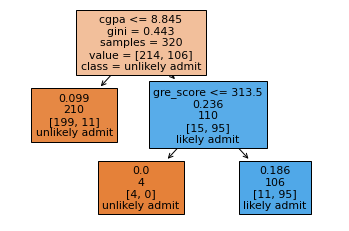

<Figure size 432x288 with 0 Axes>

In [19]:
#Plotting of the Tree, via treeplot

#Import MatPlotLib
import matplotlib.pyplot as plt
from sklearn import tree

tree.plot_tree(dt, feature_names = x_train.columns, max_depth=3,\
               class_names=['unlikely admit', 'likely admit'],\
              label='root', filled=True)
plt.show()
plt.clf()

In [20]:
#Plotting of the Tree, via text output
print(tree.export_text(dt, feature_names = X.columns.tolist()))

|--- cgpa <= 8.85
|   |--- class: False
|--- cgpa >  8.85
|   |--- gre_score <= 313.50
|   |   |--- class: False
|   |--- gre_score >  313.50
|   |   |--- class: True



In [21]:
#Verifying the Gini gain of the first decision on the tree
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)
 
gi = gini(y_train)
print(f'Gini impurity at root: {round(gi,3)}')

Gini impurity at root: 0.443


In [23]:
#Verifying the gini split table for the first decision

def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

info_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    info_gain_list.append([i, info_gain(left, right, gi)])

ig_table = pd.DataFrame(info_gain_list, columns=['split_value',\
                        'info_gain']).sort_values('info_gain', ascending=False)
ig_table.head(10)

,split_value,info_gain
10,8.84,0.296932
124,8.85,0.291464
139,8.88,0.290704
18,8.90,0.290054
98,8.83,0.287810
110,8.87,0.286050
152,8.94,0.284714
57,8.96,0.284210
96,8.80,0.283371
21,9.00,0.283364


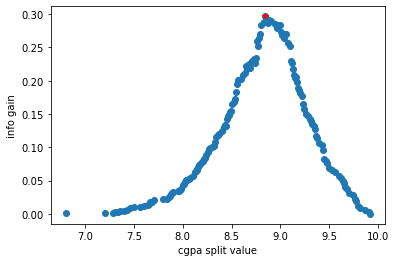

<Figure size 432x288 with 0 Axes>

In [24]:
# A quick charting of the info gain split data

plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0],ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')
plt.show()
plt.clf()

In [31]:
# Now some work on regression modeling

# X is already defined (stays the same), change definition of y to actual values instead of true/false table
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']

from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.2)
dt = DecisionTreeRegressor(max_depth=3, ccp_alpha=.001) #note: ccp_alpha changed to .001 (from .01) here and I'm not sure why yet
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print('The accuracy score is: {}'.format(dt.score(x_test, y_test)))

The accuracy score is: 0.5230242793515552


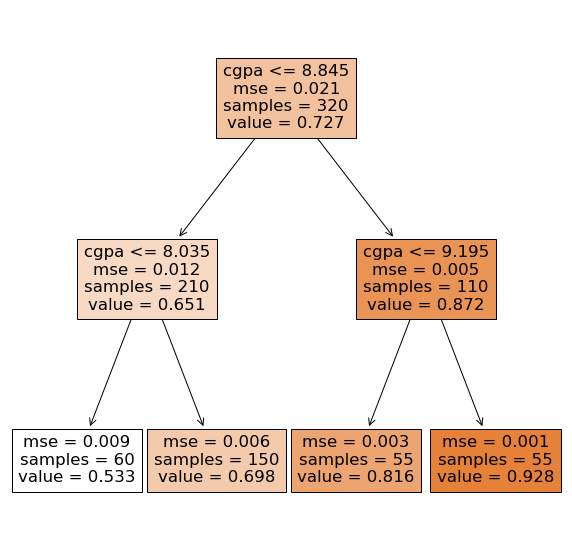

<Figure size 432x288 with 0 Axes>

In [32]:
#Graphing of the tree using regression
plt.figure(figsize = (10, 10))
tree.plot_tree(dt, feature_names = x_train.columns, max_depth = 2, filled=True)
plt.show()
plt.clf()

MSE at root: 0.02
     split_value  info_gain
10          8.84   0.010562
96          8.80   0.010534
98          8.83   0.010520
124         8.85   0.010481
125         8.73   0.010435
110         8.87   0.010429
139         8.88   0.010392
1           8.70   0.010391
17          8.76   0.010355
140         8.74   0.010347
Split with highest information gain is: None


Text(0, 0.5, 'info gain')

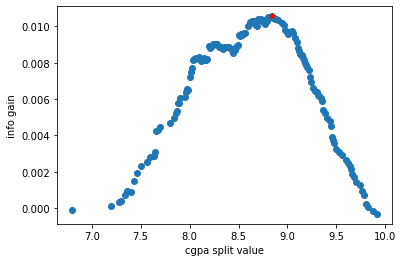

In [35]:
#Challenge section of the article, working through the mse gain (vs gini gain)

#Import NumPy
import numpy as np

#Define Functions for mse
def mse(data):
    """Calculate the MSE of a data set
    """
    return np.mean((data - data.mean())**2)
 
def mse_gain(left, right, current_mse):
    """Information Gain (MSE) associated with creating a node/split data based on MSE.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_mse - w * mse(left) - (1 - w) * mse(right)

#Walk through mse gain process
m = mse(y)
print(f'MSE at root: {round(m,3)}')
 
mse_gain_list = []
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa<=i]
    right = y_train[x_train.cgpa>i]
    mse_gain_list.append([i, mse_gain(left, right, m)])
 
mse_table = pd.DataFrame(mse_gain_list,columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
print(mse_table.head(10))
 
print(f'Split with highest information gain is: {None}')
 
plt.plot(mse_table['split_value'], mse_table['info_gain'],'o')
plt.plot(mse_table['split_value'].iloc[0], mse_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')